# How to use OpenCV to segment the cells

## Package inclusion for Python

In [1]:
%matplotlib inline

import copy
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tifffile import imsave

## Read the image from a file on the disk and return a new matrix

In [2]:
colour_image = cv2.imread("../NewCamera_171121_DSC00867.jpg", cv2.IMREAD_COLOR)

## Check for errors

In [3]:
# Check for failure
if colour_image is None: 
    raise Exception("Could not open or find the image")

## Display the image

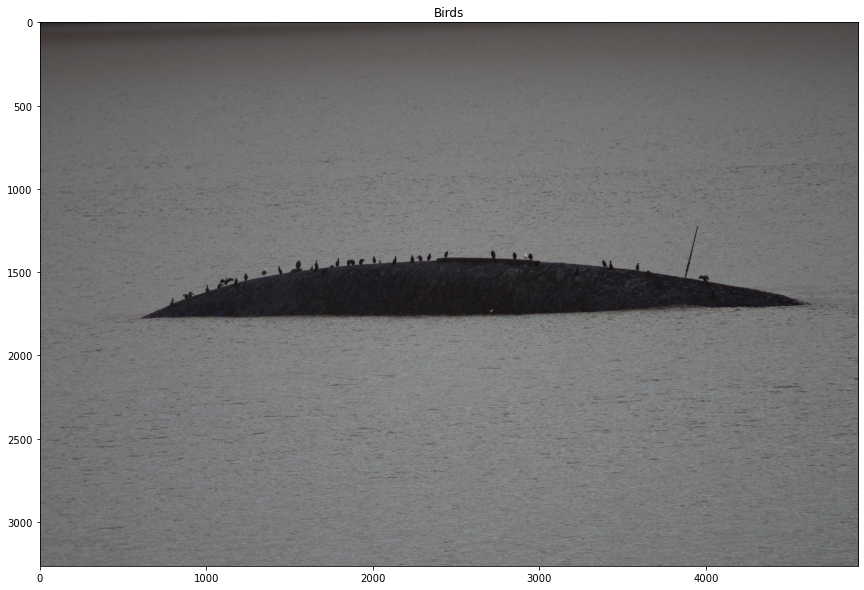

In [4]:
plt.figure(figsize=(20, 10))
plt.imshow(colour_image, cmap="gray")
plt.title('Birds')
plt.show()

## Convert to greyscale

In [5]:
grey_image = cv2.cvtColor(colour_image, cv2.COLOR_RGB2GRAY)

## Compute its histogram

In [6]:
histogram_size = 256

histogram = cv2.calcHist([grey_image], # Image to analyse
                         [0], # Number of channels
                         None, # Mask
                         [histogram_size], # Number of bins
                         [0, 255]) # Ranges

## Plot the histogram

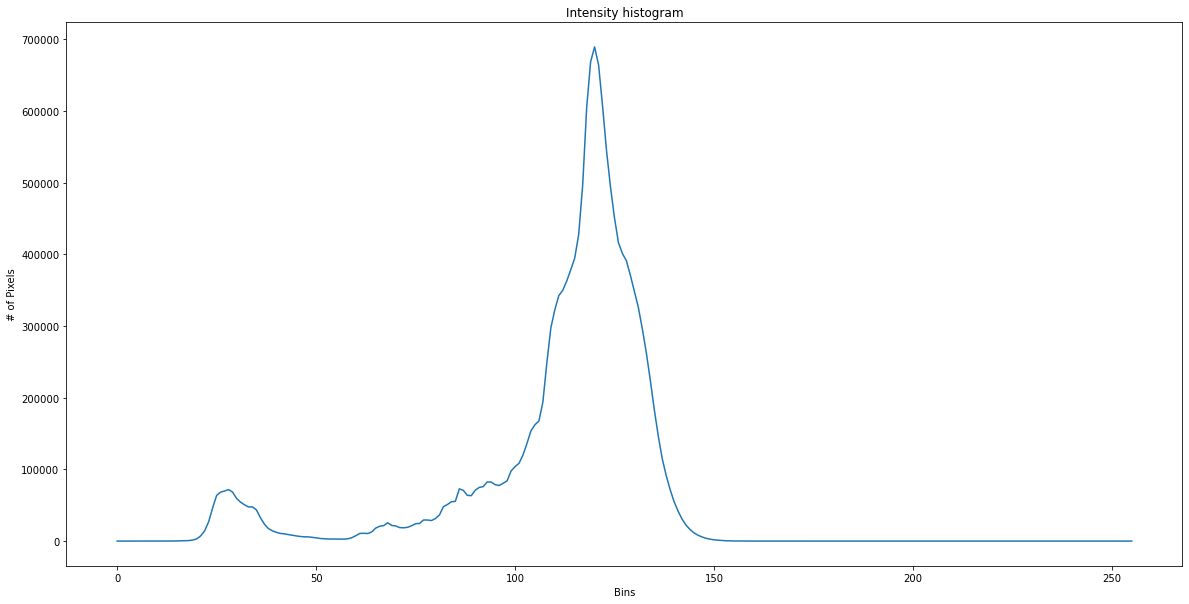

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(histogram)
plt.title('Intensity histogram')
# plt.yscale('log')
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.show()

## Binary threshold

A lot of information about the various thresholds technique in OpenCV is available at [https://docs.opencv.org/master/db/d8e/tutorial_threshold.html](https://docs.opencv.org/master/db/d8e/tutorial_threshold.html) on OpenCV's website. We want the background in black, and the cells in white. We use the inverse of the binary threshold then. See `THRESH_BINARY_INV` in [https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576).

In [8]:
segmented = None

def callback(value: int):
    global grey_image
    global threshold_value
    global segmented
    
    threshold_value = value
    
    segmented = cv2.threshold(grey_image,
          threshold_value,
          255,
          cv2.THRESH_BINARY_INV)[1]
    
    cv2.imshow("Segmentation", segmented) # Show our image inside the created window.

In [9]:
threshold_value = 65 # Taken from the histogram
callback(threshold_value)

## Display the result

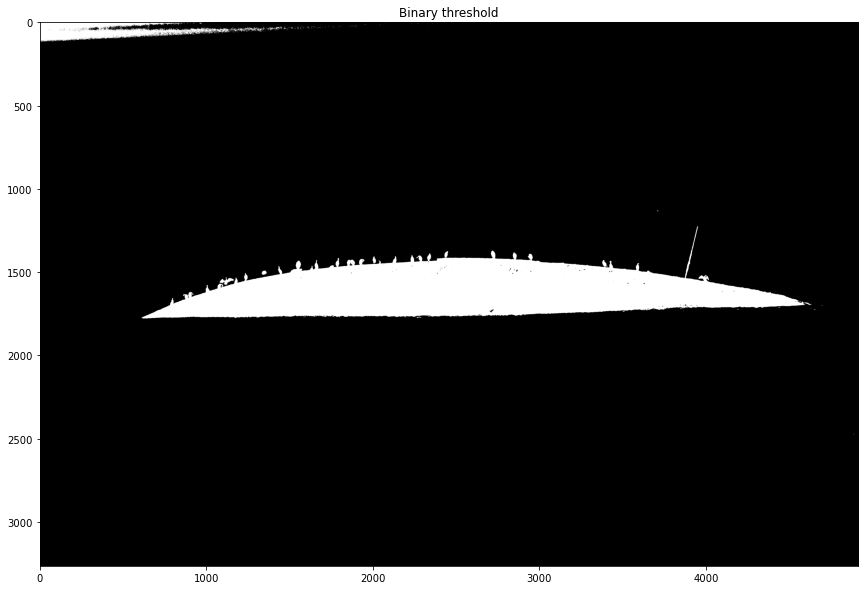

In [10]:
plt.figure(figsize=(20, 10))
plt.imshow(segmented.astype(np.uint8), cmap="gray")
plt.title('Binary threshold')
plt.show()

## Cleaning

In [11]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                    (10, 10), 
                                    (2, 2))

island_and_birds_mask = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, element);
island_and_birds_mask = cv2.morphologyEx(island_and_birds_mask, cv2.MORPH_OPEN, element);

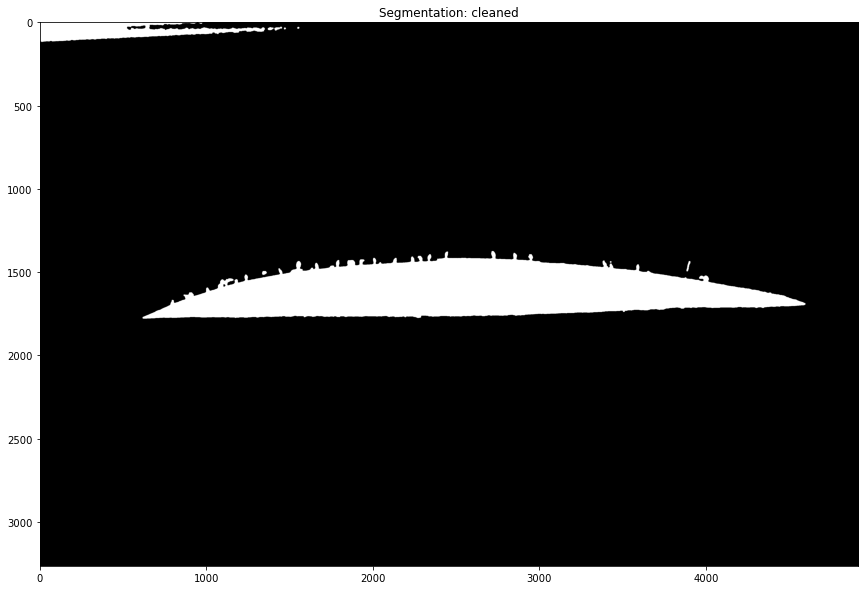

In [12]:
plt.figure(figsize=(20, 10))
plt.imshow(island_and_birds_mask, cmap="gray")
plt.title('Segmentation: cleaned')
plt.show()

In [13]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                    (30, 30), 
                                    (2, 2))

island_mask = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, element);
island_mask = cv2.morphologyEx(island_mask, cv2.MORPH_CLOSE, element);


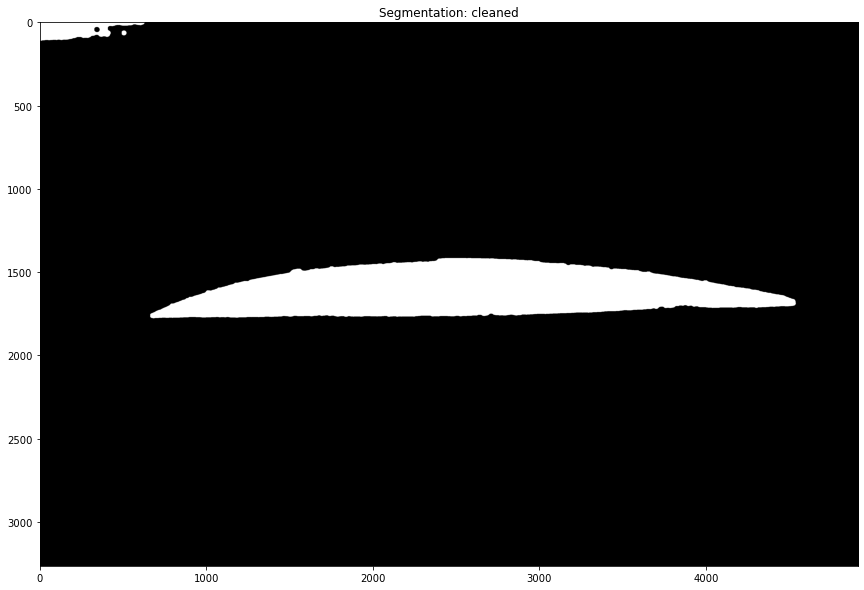

In [14]:
plt.figure(figsize=(20, 10))
plt.imshow(island_mask, cmap="gray")
plt.title('Segmentation: cleaned')
plt.show()

In [15]:
bird_mask = island_and_birds_mask - island_mask

element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                    (5, 5), 
                                    (2, 2))

bird_mask = cv2.erode(bird_mask, element, iterations = 3)

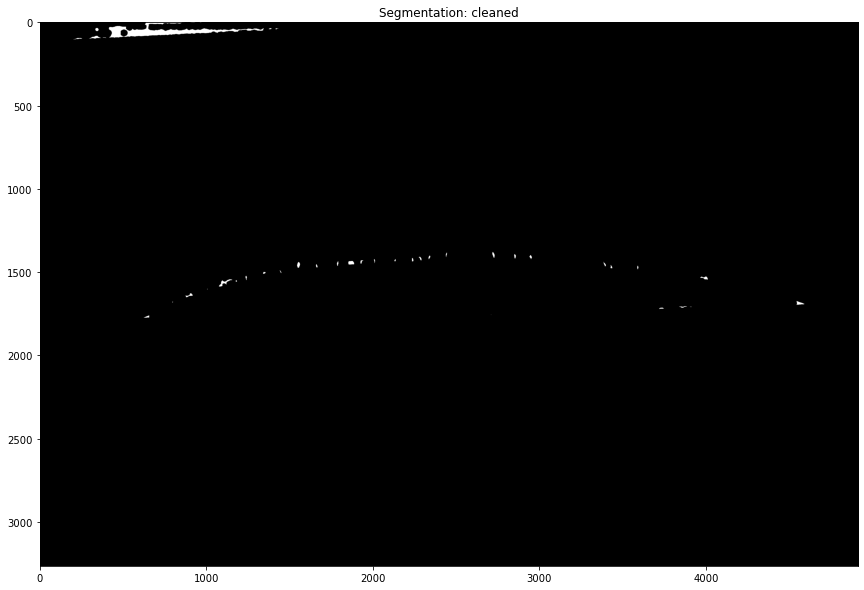

In [16]:
plt.figure(figsize=(20, 10))
plt.imshow(bird_mask, cmap="gray")
plt.title('Segmentation: cleaned')
plt.show()

## Find the birds

In [17]:
contours, hierarchy = cv2.findContours(bird_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

min_x = colour_image.shape[1]
max_x = 0

temp = []
bounding_rectangles = []

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    
    # Ignore the top of the image
    if y > 150:
        min_x = min(min_x, x)
        max_x = max(max_x, x)
        
        temp.append([x,y,w,h,cnt])

# Ignore the two extrema
for x,y,w,h,cnt in temp:
    if x != min_x and x != max_x:
        bounding_rectangles.append([x,y,w,h,cnt])

Plot the contours

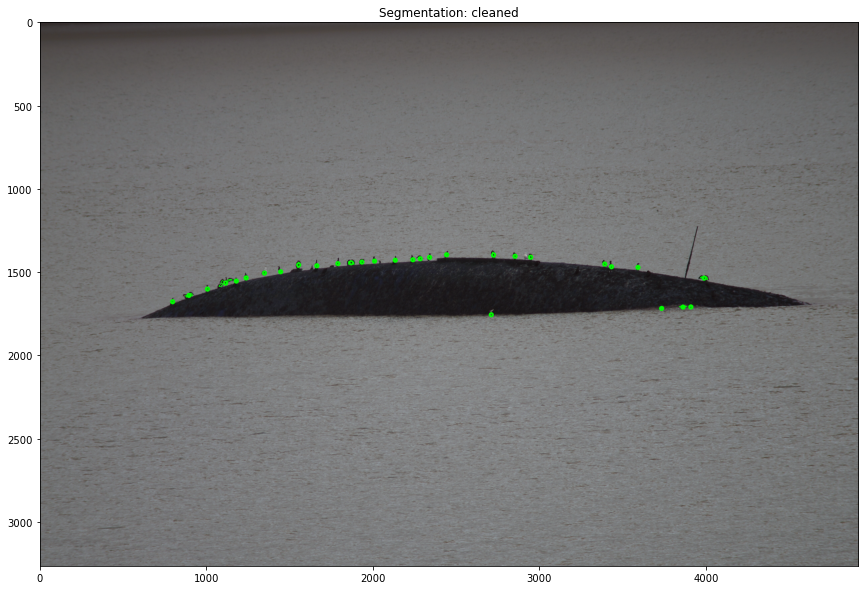

In [18]:
image_contour = copy.deepcopy(colour_image)

for x,y,w,h,cnt in bounding_rectangles:
    cv2.drawContours(image_contour, [cnt], 0, (0,255,0), 3)
    # cv2.rectangle(image_contour, (x,y), (x+w, y+h), (0,255,0), 10)
    image_contour = cv2.circle(image_contour, (round(x+w/2),round(y+h/2)), 10, (0,255,0), 10)
    
plt.figure(figsize=(20, 10))
plt.imshow(image_contour)
plt.title('Segmentation: cleaned')
plt.show()

## Removing the false positive

As you can see, four birds were detected at the bottom of the island. However, these detections are wrong as they do not correspond to birds. We will try to filter them out thanks to the direction of the image gradient.

### Compute and display the gradient

In [19]:
laplacian = cv2.Laplacian(grey_image, cv2.CV_16S)
sobelx = cv2.Sobel(grey_image, cv2.CV_16S, 1, 0, ksize=5)
sobely = cv2.Sobel(grey_image, cv2.CV_16S, 0, 1, ksize=5)

imsave("laplacian.tif", laplacian)
imsave("sobelx.tif", sobelx)
imsave("sobely.tif", sobely)

(Text(0.5, 1.0, 'Sobel Y'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

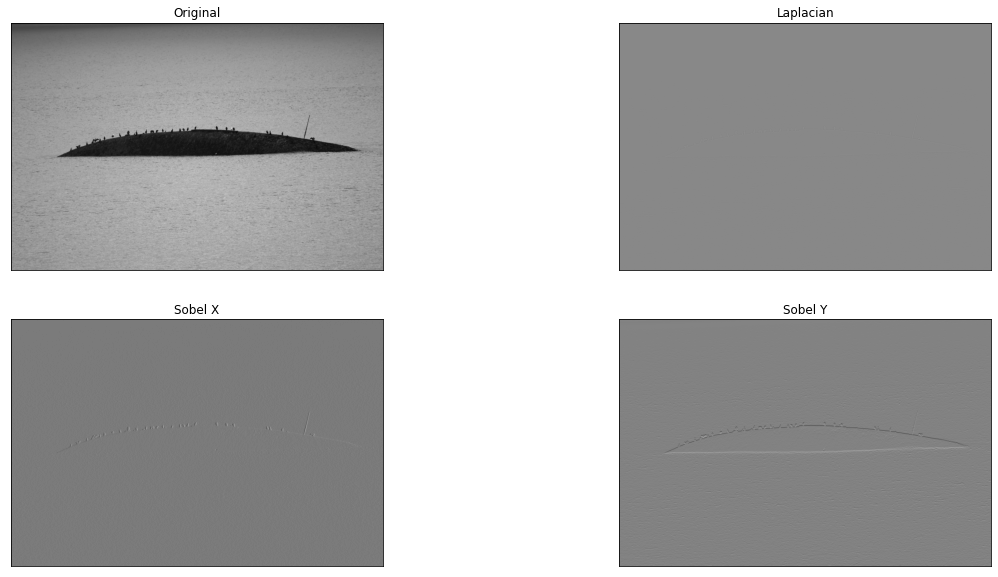

In [20]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1),plt.imshow(grey_image, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

### Filter the contours based on the gradients

From these images, we can clearly see that the false positives are alongside the line where the gradient is strictly positive in Sobel Y and null in Sobel X. We can take advantage of these two facts.

In [21]:
sobelx_colour_image = cv2.normalize(sobelx, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
sobely_colour_image = cv2.normalize(sobely, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

sobelx_colour_image = cv2.cvtColor(sobelx_colour_image, cv2.COLOR_GRAY2RGB)
sobely_colour_image = cv2.cvtColor(sobely_colour_image, cv2.COLOR_GRAY2RGB)

In [22]:
median_sobel_x = cv2.medianBlur(sobelx, 5)
median_sobel_y = cv2.medianBlur(sobely, 5)

sobelx -4520 4866
sobely -3852 3719
threshold_x 48.660000000000004
threshold_y 192.60000000000002


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


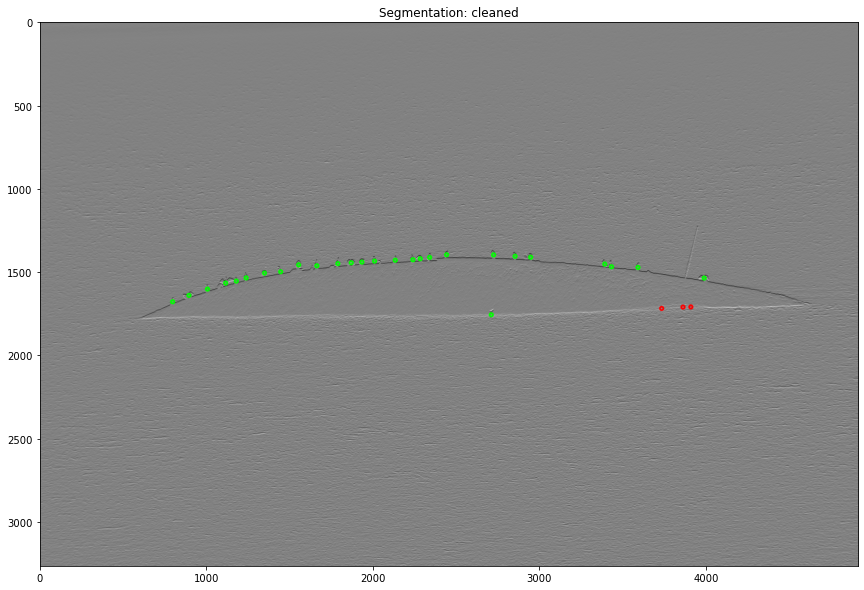

In [23]:
# image_contour = copy.deepcopy(colour_image)

# median_sobel_x = cv2.blur(sobelx, (5, 5))
# median_sobel_y = cv2.blur(sobely, (5, 5))


image_contour = copy.deepcopy(sobely_colour_image)

threshold_x = max(-sobelx.min(), sobelx.max()) * 0.01
threshold_y = max(-sobely.min(), sobely.max()) * 0.05

print("sobelx", sobelx.min(), sobelx.max())
print("sobely", sobely.min(), sobely.max())
print("threshold_x", threshold_x)
print("threshold_y", threshold_y)

bounding_rectangles = np.array(bounding_rectangles)
bounding_rectangles = bounding_rectangles[np.argsort(bounding_rectangles[:, 1])]

for x,y,w,h,cnt in bounding_rectangles:

    pixel_sobel_x = median_sobel_x[y,x]


    # If the vertical edge is large enough, then consider it's a bird
    if abs(pixel_sobel_x) > threshold_x:
        cv2.drawContours(image_contour, cnt, 0, (0,255,0), 3)
        image_contour = cv2.circle(image_contour, (round(x+w/2),round(y+h/2)), 10, (0,255,0), 10)
    # It may not be a bird
    else:
        # Create a ROI in sobel_y
        half_length = 10
        roi = median_sobel_y[y-half_length:y+half_length + 1, x-half_length: x+half_length + 1]
        
        # It's a bird
        if roi.mean() > 0:
            cv2.drawContours(image_contour, cnt, 0, (255,0,0), 3)
            image_contour = cv2.circle(image_contour, (round(x+w/2),round(y+h/2)), 10, (255, 0,0), 10)
        # It's not a bird
        else:
            cv2.drawContours(image_contour, cnt, 0, (0,255,0), 3)
            image_contour = cv2.circle(image_contour, (round(x+w/2),round(y+h/2)), 10, (0,255,0), 10)
            
            
plt.figure(figsize=(20, 10))
plt.imshow(image_contour)
plt.title('Segmentation: cleaned')
plt.show()

In [24]:
cv2.destroyAllWindows() # Destroy all the created windows